# Step 2 — Split & Preprocess (BankChurners)

**Goal.** Create a leakage-safe **train/test split** and a reusable **preprocessing pipeline**:
- One-Hot Encode categoricals (drop a redundant level for binary fields)
- Standardize numerics
- Persist artifacts for modeling and explainability (feature names, transformer)

**Why this matters.**
A clean split and consistent preprocessing are non-negotiable for credible metrics, fair comparisons between models, and reproducibility across environments.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import json

PROC = Path("../data/processed"); PROC.mkdir(parents=True, exist_ok=True)
MODELS = Path("../models"); MODELS.mkdir(parents=True, exist_ok=True)

pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


## Load the processed dataset

I use the output from Step 1 (`bankchurners_processed.csv`).  
This file already includes a stable `id`, the binary `churn` target, and several engineered features.


In [2]:
df = pd.read_csv(PROC / "bankchurners_processed.csv")
print("Shape:", df.shape)
df.head(27)

Shape: (10127, 26)


,id,churn,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,avg_trans_amt,trans_per_month,contact_rate_12m,inactive_3plus_12m,util_band
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1.335,1144,42,1.625,0.061,27.238,3.500,0.250,0,very_low
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1.541,1291,33,3.714,0.105,39.121,2.750,0.167,0,low
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,2.594,1887,20,2.333,0.000,94.350,1.667,0.000,0,very_low
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1.405,1171,20,2.333,0.760,58.550,1.667,0.083,1,high
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,2.175,816,28,2.500,0.000,29.143,2.333,0.000,0,very_low
5,713061558,0,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,1.376,1088,24,0.846,0.311,45.333,2.000,0.167,0,medium
6,810347208,0,51,M,4,Unknown,Married,$120K +,Gold,46,...,1.975,1330,31,0.722,0.066,42.903,2.583,0.250,0,very_low
7,818906208,0,32,M,0,High School,Unknown,$60K - $80K,Silver,27,...,2.204,1538,36,0.714,0.048,42.722,3.000,0.167,0,very_low
8,710930508,0,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,3.355,1350,24,1.182,0.113,56.250,2.000,0.000,0,low
9,719661558,0,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,1.524,1441,32,0.882,0.144,45.031,2.667,0.250,1,low


## Feature sets

We keep `id` (for joins/visuals) out of modeling features and use:
- **Categoricals:** card tier, demographics, etc. → One-Hot
- **Numerics:** usage, inactivity, utilization, engineered rates → Standardize

Binary categoricals will use `drop="if_binary"` so we don’t create redundant columns.


In [3]:
assert "churn" in df.columns, "Target 'churn' missing."

id_col = "id" if "id" in df.columns else None
target = "churn"

# Candidate categorical & numeric columns (subset by presence)
cat_candidates = [
    "gender","education_level","marital_status","income_category","card_category","util_band"
]
num_candidates = [
    "customer_age","dependent_count","months_on_book","total_relationship_count",
    "months_inactive_12_mon","contacts_count_12_mon",
    "credit_limit","total_revolving_bal","avg_open_to_buy",
    "total_amt_chng_q4_q1","total_trans_amt","total_trans_ct",
    "total_ct_chng_q4_q1","avg_utilization_ratio",
    "avg_trans_amt","trans_per_month","contact_rate_12m","inactive_3plus_12m"
]

cat_cols = [c for c in cat_candidates if c in df.columns]
num_cols = [c for c in num_candidates if c in df.columns]

# Final modeling frame (keep id separately for later joins)
use_cols = ([id_col] if id_col else []) + [target] + cat_cols + num_cols
data = df[use_cols].copy()

print("Categoricals:", cat_cols)
print("Numerics:", num_cols)
print("Modeling frame shape:", data.shape)


Categoricals: ['gender', 'education_level', 'marital_status', 'income_category', 'card_category', 'util_band']
Numerics: ['customer_age', 'dependent_count', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio', 'avg_trans_amt', 'trans_per_month', 'contact_rate_12m', 'inactive_3plus_12m']
Modeling frame shape: (10127, 26)


## Stratified split (25% test)

We stratify on `churn` to preserve class balance across splits.  
This avoids misleading metrics caused by different churn rates in train vs test.


Train shape: (7595, 25) Test shape: (2532, 25)
Churn rate (train): 16.063%
Churn rate (test) : 16.074%


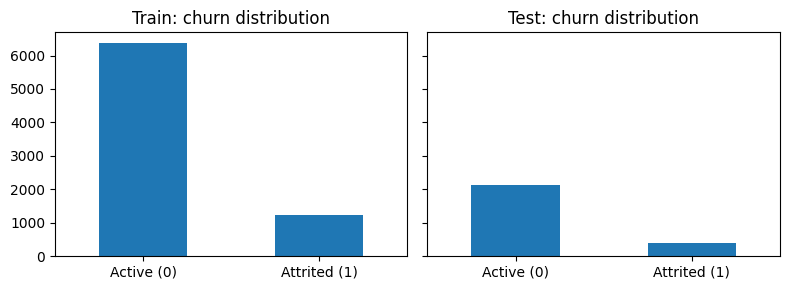

In [4]:
y = data[target].astype(int).values
X = data.drop(columns=[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

def rate(v): return float(np.mean(v))

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print(f"Churn rate (train): {rate(y_train):.3%}")
print(f"Churn rate (test) : {rate(y_test):.3%}")

# Visual check of class balance
fig, ax = plt.subplots(1,2, figsize=(8,3), sharey=True)
pd.Series(y_train).value_counts().sort_index().plot(kind="bar", ax=ax[0], title="Train: churn distribution")
pd.Series(y_test).value_counts().sort_index().plot(kind="bar", ax=ax[1], title="Test: churn distribution")
for a in ax: a.set_xticklabels(["Active (0)","Attrited (1)"], rotation=0)
plt.tight_layout(); plt.show()


## Preprocessing pipeline

- **Categoricals → OneHotEncoder** (`handle_unknown="ignore"`, `drop="if_binary"`)
- **Numerics → StandardScaler** (zero mean, unit variance)

We keep this as a **single `ColumnTransformer`** to plug directly into model pipelines (Logistic, XGBoost, etc.).


In [5]:
pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="if_binary"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

# Fit on TRAIN ONLY (test must remain unseen)
pre.fit(X_train)

# Transform once to verify shape
Xt_train = pre.transform(X_train)
Xt_test  = pre.transform(X_test)
print("Encoded shapes:", Xt_train.shape, Xt_test.shape)


Encoded shapes: (7595, 45) (2532, 45)


## Feature names (post-encoding)

For SHAP/feature importance later, we capture the **expanded** feature names:
- OHE outputs one column per category level (minus the dropped binary level)
- Numerics keep their original names (but are scaled)


In [6]:
# OHE names
ohe = pre.named_transformers_["cat"]
ohe_names = list(ohe.get_feature_names_out(cat_cols)) if cat_cols else []

# Numeric names (as-is)
num_names = num_cols

feature_names = ohe_names + num_names
print("Total encoded features:", len(feature_names))
print("Sample:", feature_names[:10])

# Persist for reuse
(MODELS / "feature_names.json").write_text(json.dumps(feature_names, indent=2))
print("Saved:", (MODELS / "feature_names.json").as_posix())


Total encoded features: 45
Sample: ['gender_M', 'education_level_College', 'education_level_Doctorate', 'education_level_Graduate', 'education_level_High School', 'education_level_Post-Graduate', 'education_level_Uneducated', 'education_level_Unknown', 'marital_status_Divorced', 'marital_status_Married']
Saved: ../models/feature_names.json


## Persist artifacts

We save:
- `train.csv` / `test.csv` with `id` and `churn` to keep splits deterministic  
- The fitted `preprocessor` for modeling (Step 3)  
- Column lists for traceability

In [7]:
# Save splits (ids + target so we can join back scores later)
train_out = X_train.copy()
test_out  = X_test.copy()
train_out[target] = y_train
test_out[target]  = y_test

train_out.to_csv(PROC / "train.csv", index=False)
test_out.to_csv(PROC / "test.csv", index=False)

print("Wrote splits:", (PROC / "train.csv").name, (PROC / "test.csv").name)

# Save column lists
(PROC / "cat_cols.json").write_text(json.dumps(cat_cols))
(PROC / "num_cols.json").write_text(json.dumps(num_cols))
print("Saved cat/num column manifests.")

# Save transformer
from joblib import dump
dump(pre, MODELS / "preprocessor.joblib")
print("Saved:", (MODELS / "preprocessor.joblib").as_posix())

Wrote splits: train.csv test.csv
Saved cat/num column manifests.
Saved: ../models/preprocessor.joblib


## Sanity visuals — are splits comparable?

We verify that **train vs test** look similar on a few key fields (random split should look alike):
- Numeric example: `trans_per_month`
- Categorical example: `card_category`

These are smoke tests to detect accidental bias in the split (e.g., if all Platinum ended up in test).


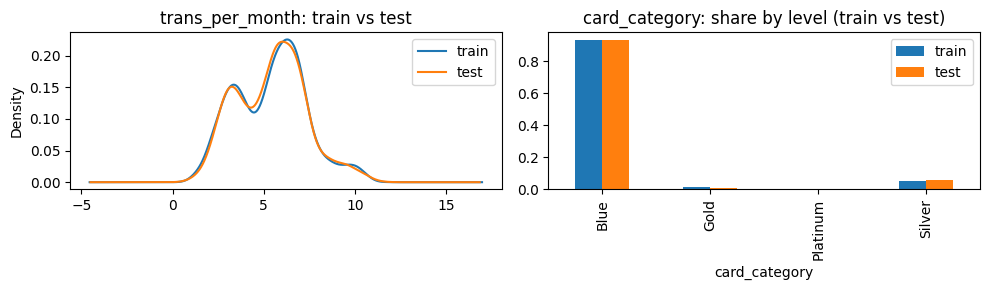

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

# Numeric overlay
num_probe = "trans_per_month" if "trans_per_month" in X_train.columns else None
if num_probe:
    X_train[num_probe].plot(kind="kde", ax=ax[0], label="train")
    X_test[num_probe].plot(kind="kde",  ax=ax[0], label="test")
    ax[0].set_title(f"{num_probe}: train vs test"); ax[0].legend()

# Categorical proportions
cat_probe = "card_category" if "card_category" in X_train.columns else None
if cat_probe:
    p_train = X_train[cat_probe].value_counts(normalize=True).sort_index()
    p_test  = X_test[cat_probe].value_counts(normalize=True).sort_index()
    pd.concat({"train": p_train, "test": p_test}, axis=1).plot(kind="bar", ax=ax[1])
    ax[1].set_title(f"{cat_probe}: share by level (train vs test)"); ax[1].legend()

plt.tight_layout(); plt.show()


### Next (Step 3): Modeling

- **Baseline:** Logistic Regression with class_weight="balanced"
- **Stronger:** Gradient Boosting / XGBoost
- **Calibration:** Isotonic/Platt for decision-ready probabilities
- **Diagnostics:** ROC/PR curves, confusion matrix at operating point, SHAP drivers
